In [1]:
!pip install Bayesian-Optimization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit

In [9]:
train = pd.read_csv('./train_pre3.csv')
test = pd.read_csv('./test_pre3.csv')
valid = pd.read_csv('./valid_pre3.csv')

### f1 score 정의

In [10]:
from sklearn.metrics import f1_score
# lgbm은 f1 score를 제공하지 않으므로 새로 정의
def lgb_f1_score(y_hat, data):
    y_true = data.get_label().astype(int)
    y_hat = np.round(y_hat).astype(int) # 실수 예측값을 반올림하여 1,0으로 변경
    return 'f1', f1_score(y_true, y_hat), True

### 모델링 준비

In [11]:
# 변수 선택
input_var = list(set(train.columns) - set(['id','dt_of_fr','year','fr_yn']))
target = ['fr_yn']

# 카테고리 컬럼 정의
cat_col = []
for col in train[input_var].columns:
    if (train[col].dtype == 'object'):
        cat_col.append(col)
    
cat_col = cat_col + ['month','hour','weekday','wnd_drctn']

for col in tqdm_notebook(train.columns): 
    if col in cat_col:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(valid[col].astype(str).values)+ list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        valid[col] = le.transform(list(valid[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))
        
# 카테고리 컬럼은 lgbm이 인식하도록 category 타입으로 변경
for i in enumerate (cat_col) : 
    ca = i[1] 
    train[ca] = train[ca].astype('category') 
    valid[ca] = valid[ca].astype('category') 
    test[ca] = test[ca].astype('category') 

# 훈련, 검증할 데이터 셋
X_train = train[input_var]
y_train = train['fr_yn']

X_valid = valid[input_var]
y_valid = valid['fr_yn']

### Bayesian Optimization

- valid를 k등분하여 교차검증 실시(dtrain = train + valid*(k-1/k) )

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit

def LGB_bayesian(
    num_leaves, 
    bagging_freq,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda,
    learning_rate,
    neg_bagging_fraction,
    pos_bagging_fraction,
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    
    num_leaves = int(num_leaves)
    bagging_freq = int(bagging_freq)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(bagging_freq) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': int(round(num_leaves)), 
              'min_data_in_leaf': int(round(min_data_in_leaf)),
              'min_child_weight': min_child_weight,
              'bagging_freq' : int(round(bagging_freq)),
              'feature_fraction' : feature_fraction,
              'learning_rate' : learning_rate,
              'max_depth': int(round(max_depth)),
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              #'subsample_freq ': subsample_freq,
              'pos_bagging_fraction':pos_bagging_fraction,
              'neg_bagging_fraction':neg_bagging_fraction,        
              'objective': 'binary',
              'use_missing': True,
              'n_estimators': 1000000,
              'save_binary': True,
              'seed': 42,
              'feature_fraction_seed': 42,
              'bagging_seed': 42,
              'drop_seed': 42,
              'data_random_seed': 42,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': True,
              'boost_from_average': True,
              'metric':'None'}   

    cv_results = []          
    n_splits = 10
    split = StratifiedKFold(n_splits=n_splits, shuffle=False ,random_state=42)
    split.get_n_splits(X_valid, y_valid)

    for train_index, test_index in split.split(X_valid, y_valid):
      X1_valid, X2_valid = X_valid.iloc[train_index], X_valid.iloc[test_index]
      y1_valid, y2_valid = y_valid[train_index], y_valid[test_index]

      X2_train = pd.concat([X_train, X1_valid], axis=0)
      y2_train = pd.concat([y_train, y1_valid], axis=0)

      for i in enumerate (cat_col2) : 
        ca = i[1] 
        X2_train[ca] = X2_train[ca].astype('category') 
  
      dtrain = lgb.Dataset(X2_train, label=y2_train)
      dvalid = lgb.Dataset(X2_valid, label=y2_valid)

      cv_result = lgb.train(param, dtrain,  valid_sets = [dtrain, dvalid], verbose_eval =1000, feval= lgb_f1_score,
                            categorical_feature= cat_col2, early_stopping_rounds = 500)
      cv_results.append(cv_result.best_score['valid_1']['f1'])   

    return np.mean(cv_results)

### Paramater
- 최종 파라미터

In [12]:
params = {
 'bagging_freq': 13,
 'feature_fraction': 0.5546,
 'learning_rate': 0.009532,
 'max_depth': 74,
 'min_child_weight': 0.02659,
 'min_data_in_leaf': 56,
 'neg_bagging_fraction': 0.9729,
 'num_leaves': 198,
 'pos_bagging_fraction': 0.892,
 'reg_alpha': 3.156,
 'reg_lambda': 3.974,
 'objective': 'binary',
 'use_missing': True,
 'n_estimators': 10000,
 'save_binary': True,
 'seed': 42,
 'feature_fraction_seed': 42,
 'bagging_seed': 42,
 'drop_seed': 42,
 'data_random_seed': 42,
 'boosting_type': 'gbdt',
 'verbose': 1,
 'is_unbalance': True,
 'boost_from_average': True,
 'metric':'None'}

In [16]:
import warnings
warnings.filterwarnings("ignore")
submission = pd.read_csv('./PJT002_submission.csv')
submission['fr_yn'] = 0
X_train = train[input_var]
y_train = train['fr_yn']

X_valid = valid[input_var]
y_valid = valid['fr_yn']

CV= []
n_splits = 10 # k가 너무 크면 각 fold별로 예측값의 변동이 너무 커진다는 문제가 있다.

split = StratifiedKFold(n_splits=n_splits, shuffle=True ,random_state=42)
split.get_n_splits(X_valid, y_valid)
for train_index, test_index in split.split(X_valid, y_valid):
    X1_valid, X2_valid = X_valid.iloc[train_index], X_valid.iloc[test_index]
    y1_valid, y2_valid = y_valid[train_index], y_valid[test_index]

    X2_train = pd.concat([X_train, X1_valid], axis=0)
    y2_train = pd.concat([y_train, y1_valid], axis=0)

    for i in enumerate (cat_col) : 
      ca = i[1] 
      X2_train[ca] = X2_train[ca].astype('category') 

    dtrain = lgb.Dataset(X2_train, label=y2_train)
    dvalid = lgb.Dataset(X2_valid, label=y2_valid)
    model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], feval= lgb_f1_score,
                        verbose_eval=50, early_stopping_rounds=100,
                        categorical_feature = cat_col)
    CV.append(model.best_score['valid_1']['f1'])
    # predict
    submission['fr_yn'] += model.predict(test[input_var])
submission['fr_yn'] = submission['fr_yn'] / n_splits
print('CV mean {}, CV std {}'.format(np.mean(CV), np.std(CV)))

Training until validation scores don't improve for 100 rounds
[50]	training's f1: 0	valid_1's f1: 0
[100]	training's f1: 0.572484	valid_1's f1: 0.5
[150]	training's f1: 0.622627	valid_1's f1: 0.482574
Early stopping, best iteration is:
[83]	training's f1: 0.473218	valid_1's f1: 0.528139
Training until validation scores don't improve for 100 rounds
[50]	training's f1: 0	valid_1's f1: 0
[100]	training's f1: 0.571479	valid_1's f1: 0.510204
[150]	training's f1: 0.621335	valid_1's f1: 0.504021
[200]	training's f1: 0.629686	valid_1's f1: 0.483951
Early stopping, best iteration is:
[101]	training's f1: 0.57556	valid_1's f1: 0.513514
Training until validation scores don't improve for 100 rounds
[50]	training's f1: 0	valid_1's f1: 0
[100]	training's f1: 0.572385	valid_1's f1: 0.505051
[150]	training's f1: 0.623513	valid_1's f1: 0.466488
Early stopping, best iteration is:
[83]	training's f1: 0.474674	valid_1's f1: 0.543103
Training until validation scores don't improve for 100 rounds
[50]	traini

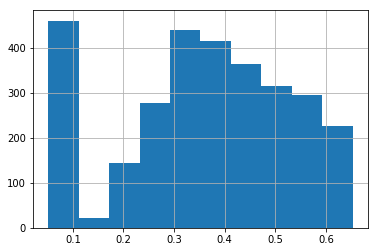

In [17]:
# 타겟 분포 확인
submission['fr_yn'].hist()

In [18]:
submission['fr_yn'] = np.where(submission['fr_yn']>=0.5, 'Y', 'N')
#submission.to_csv('./ajk2000000_화재예측과제_Submission.csv', index=False)

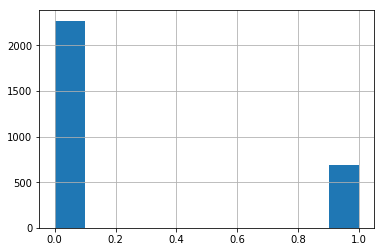

In [21]:
# str 타입은 hist 찍으면 시간이 매우 오래 걸리므로 다시 int형으로 변경
submission['fr_yn2'] = np.where(submission['fr_yn']=='Y', 1, 0)
submission['fr_yn2'].hist()

### 결론

- 최종점수: 리더보드에는 0.5184 기록(최종 16위/351)
- 아쉬운 점: 대회에 늦게 참가하여, 결측치 처리나 변수 생성에 엉성한 점이 많았다.

     1)  결측치 처리: 군집화를 통해서 결측치 처리도 가능할 것 같다.
     
     2) 변수 생성: 화재를 고려해 건물 및 토지 용도에 따라 용적률과 건폐율 등의 개념을 사용하는데 이런 것들을 변수로 넣었으면 더 좋지 않을까 한다. 
     
     3) 시계열 데이터: 시계열 데이터의 특징을 가장 잘 뽑는 방법이 무엇일지, 계속되는 고민이다.